In [11]:
# imports
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import time
import networkx as nx
from tqdm import tqdm
import pickle

In [2]:
# constants
budget = 40

In [3]:
def IC(g,S,p=0.5,mc=1000):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """

    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                
                node_dict = dict(g[node])
                node_neighbours = list(node_dict.keys())

                # Determine neighbors that become infected
                np.random.seed(i)
                success = np.random.uniform(0,1,len(g[node])) < p
                new_ones += list(np.extract(success, node_neighbours))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active
            
        spread.append(len(A))
        
    return(np.mean(spread))

In [4]:
def greedy(g,k,p=0.1,mc=1000,node_cost_dict={}, budget=budget):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    S, spread, timelapse, start_time = [], [], [], time.time()
    
    # Find k nodes with largest marginal gain
    for _ in tqdm(range(k)):
        node = None

        # Loop over nodes that are not yet in seed set to find biggest marginal gain
        best_spread = 0
        # for j in set(range(len(g.nodes)))-set(S):
        for j in set(g.nodes)-set(S):

            if node_cost_dict[j]<=budget:
                # Get the spread
                s = IC(g,S + [j],p,mc)/node_cost_dict[j]

                # Update the winning node and spread so far
                if s > best_spread:
                    best_spread, node = s, j
                    budget = budget - node_cost_dict[j]

        if node != None:
            # Add the selected node to the seed set
            S.append(node)
            
            # Add estimated spread and elapsed time
            spread.append(best_spread)
            timelapse.append(time.time() - start_time)

    return(S,spread,timelapse)

In [5]:
def celf(g,k,p=0.1,mc=1000,node_cost_dict={}, budget=budget):  
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
      
    # --------------------
    # Find the first node with greedy algorithm
    # --------------------
    
    # Calculate the first iteration sorted list
    start_time = time.time() 
    #marg_gain = [IC(g,[node],p,mc) for node in range(len(g.nodes))]
    marg_gain = []
    # for node in range(len(g.nodes)):
    for node in g.nodes:
        marg_gain.append(IC(g,[node],p,mc)/node_cost_dict[node])

    # Create the sorted list of nodes and their marginal gain 
    # Q = sorted(zip(range(len(g.nodes)),marg_gain), key=lambda x: x[1],reverse=True)
    Q = sorted(zip(g.nodes,marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [len(g.nodes)], [time.time()-start_time]
    budget = budget - node_cost_dict[Q[0][0]]
    
    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------

    for _ in tqdm(range(k-1)):    

        check, node_lookup = False, 0

        # Shorten the candidate list based on whether the cost of a node is less or equal to our budget
        j=0
        while j < len(Q):
            if node_cost_dict[Q[j][0]] > budget:
                Q.pop(j)
                j = j-1
            j = j+1
        
        if Q:
            while not check:
                
                # Count the number of times the spread is computed
                node_lookup += 1
                
                # Recalculate spread of top node
                current = Q[0][0]
                
                # Evaluate the spread function and store the marginal gain in the list
                marg_gain = (IC(g,S+[current],p,mc)/node_cost_dict[current]) - spread
                Q[0] = (current,marg_gain)

                # Re-sort the list
                Q = sorted(Q, key = lambda x: x[1], reverse = True)

                # Check if previous top node stayed on top after the sort
                check = (Q[0][0] == current)

            # Select the next node
            spread += Q[0][1]
            S.append(Q[0][0])
            budget = budget - node_cost_dict[Q[0][0]]
            SPREAD.append(spread)
            LOOKUPS.append(node_lookup)
            timelapse.append(time.time() - start_time)

            # Remove the selected node from the list
            Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)

In [6]:
big_file = r'bigfile.txt'
small_file = r'smallfile.txt'

filehandler = open(big_file, 'r',encoding='utf-8')
Lines = filehandler.readlines()

In [7]:
# parameter weight_flag
weight_flag = False

edge_list = list()
for line in Lines:
    # if you use big_file then below line should be: tokens = line.strip().split('\t')
    tokens = line.strip().split('\t')
    node1 = (int)(tokens[0])-1
    node2 = (int)(tokens[1])-1
    if (weight_flag):
        weight = (float)(tokens[2])
        edge = (node1,node2,weight)
    else:
        edge = (node1,node2)
    edge_list.append(edge)

In [8]:
# construct the network
g = nx.Graph()
g.add_edges_from(edge_list)

In [9]:
# demoooooo
# source = [0,1,2,4]
# target = [3,3,3,3]
# edge_list = zip(source,target)

# node_cost_dict = dict()
# node_cost_dict[0] = 2
# node_cost_dict[1] = 3
# node_cost_dict[2] = 3
# node_cost_dict[4] = 2
# node_cost_dict[3] = 5
#--------------------------------------------------------------------------------
# source = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,3,4,5]
# target = [2,3,4,5,6,7,8,9,2,3,4,5,6,7,8,9,6,7,8,9]
# edge_list = zip(source,target)

# # cost_list = [1,2,3,4,5]
# node_cost_dict = dict()
# for i in g.nodes:
#     if g.degree(i)>=6:
#         node_cost_dict[i] = 5
#     elif g.degree(i)>=5 and g.degree(i)<6:
#         node_cost_dict[i] = 4
#     elif g.degree(i)>=4 and g.degree(i)<5:
#         node_cost_dict[i] = 3
#     elif g.degree(i)>=2 and g.degree(i)<4:
#         node_cost_dict[i] = 2
#     else:
#         node_cost_dict[i] = 1
#----------------------------------------------------------------------------------
# cost_list = [1,2,3,4,5]
node_cost_dict = dict()
for i in g.nodes:
    if g.degree(i)>=400:
        node_cost_dict[i] = 5
    elif g.degree(i)>=300 and g.degree(i)<400:
        node_cost_dict[i] = 4
    elif g.degree(i)>=200 and g.degree(i)<300:
        node_cost_dict[i] = 3
    elif g.degree(i)>=100 and g.degree(i)<200:
        node_cost_dict[i] = 2
    else:
        node_cost_dict[i] = 1
#----------------------------------------------------------------------------------
# cost_list = [1,2,3,4,5]
# node_cost_dict = dict()
# for i in g.nodes:
#     if g.degree(i)>=40:
#         node_cost_dict[i] = 5
#     elif g.degree(i)>=30 and g.degree(i)<40:
#         node_cost_dict[i] = 4
#     elif g.degree(i)>=20 and g.degree(i)<30:
#         node_cost_dict[i] = 3
#     elif g.degree(i)>=10 and g.degree(i)<20:
#         node_cost_dict[i] = 2
#     else:
#         node_cost_dict[i] = 1

In [10]:
celf_output   = celf(g,10,p = 0.2,mc = 20, node_cost_dict=node_cost_dict, budget=budget)
print("celf output:   " + str(celf_output[0]))

# save results
output_dict = dict()
output_dict['celf_output'] = celf_output
output_file = 'celf_outputsensornumber' + str(10) + '.pickle'
with open(output_file, 'wb') as handle:
    pickle.dump(output_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 2/2 [03:03<00:00, 91.80s/it]

celf output:   [0, 259]
greedy output: [0, 259]


In [ ]:
greedy_output = greedy(g,10,p = 0.2,mc = 20, node_cost_dict=node_cost_dict, budget=budget)
print("greedy output: " + str(greedy_output[0]))

# save results
output_dict = dict()
output_dict['greedy_output'] = greedy_output
output_file = 'output_greedysensornumber' + str(10) + '.pickle'
with open(output_file, 'wb') as handle:
    pickle.dump(output_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
# import pickle
# output_dict = dict()
# output_dict['celf_output'] = celf_output
# output_dict['greedy_output'] = greedy_output
# output_file = 'output_file_sensornumber_' + str(2) + '.pickle'
# with open(output_file, 'wb') as handle:
#     pickle.dump(output_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open(output_file, 'rb') as handle:
#     b = pickle.load(handle)

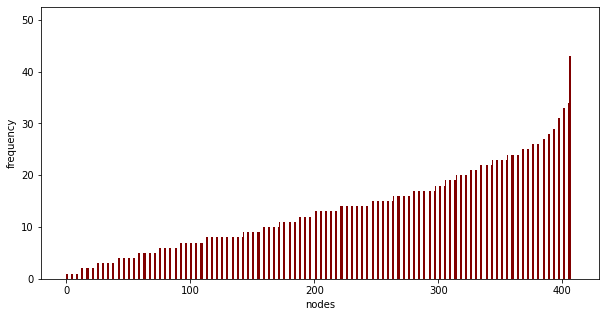

In [11]:
# import numpy as np
# import matplotlib.pyplot as plt

# # creating the dataset
# # x_values = [i for i in range(len(g.nodes))]
# # y_values = [g.degree(i) for i in range(len(g.nodes)) if g.has_node(i)]

# x_values = []
# y_values = []
# for i in range(len(g.nodes)):
#         if g.has_node(i):
#                 x_values.append(i) 
#                 y_values.append(g.degree(i))
  
# fig = plt.figure(figsize = (10, 5))
 
# # creating the bar plot
# plt.bar(x_values, sorted(y_values), color ='maroon',
#         width = 0.4)
 
# plt.xlabel("nodes")
# plt.ylabel("frequency")
# # plt.title("Students enrolled in different courses")
# plt.show()

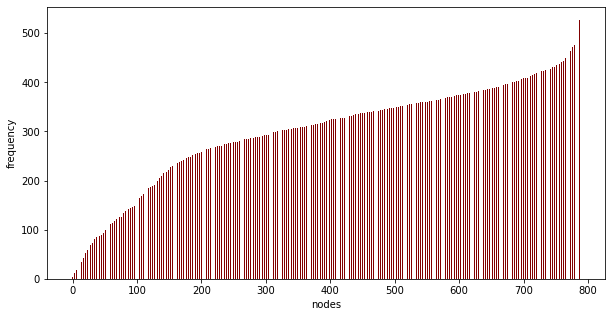

In [28]:
# import numpy as np
# import matplotlib.pyplot as plt

# # creating the dataset
# # x_values = [i for i in range(len(g.nodes))]
# # y_values = [g.degree(i) for i in range(len(g.nodes)) if g.has_node(i)]

# x_values = []
# y_values = []
# for i in range(len(g.nodes)):
#         if g.has_node(i):
#                 x_values.append(i) 
#                 y_values.append(g.degree(i))
  
# fig = plt.figure(figsize = (10, 5))
 
# # creating the bar plot
# plt.bar(x_values, sorted(y_values), color ='maroon',
#         width = 0.4)
 
# plt.xlabel("nodes")
# plt.ylabel("frequency")
# # plt.title("Students enrolled in different courses")
# plt.show()